In [25]:
import pylab 
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
import random
import os 
from PIL import Image 

In [26]:
def crawl_folder(folder_path): #search_str 찾고자 하는 string 
    search_path_list=[]
    fileList = os.walk(folder_path).next()[2]
    subFolder_list = os.walk(folder_path).next()[1]
    if(len(fileList)!=0):
        for j in range(len(fileList)):
            search_path_list.append(folder_path+'/'+fileList[j])
    if len(subFolder_list)==0:
        return search_path_list
    else: 
        for i in range(len(subFolder_list)):
            search_path_list.extend(crawl_folder(folder_path+'/'+subFolder_list[i] ))
        return search_path_list


In [27]:
def ConstraintSize(path_list , constraint_row , constraint_col ): #lst_ involves Path 
    print len(path_list)
    returend_path_list=[]
    count=0
    for ele in path_list:
        
        if type(ele)==str:
            if ".dcm" in ele:
                ds = dicom.read_file(ele)
                try:
                    pic_np=ds.pixel_array
                except ValueError as ve:
                    continue
            elif ".bmp" in ele:
                img=Image.open(ele)
                pic_np=np.array(img)
        
        elif  'numpy' in str(type(ele)):
            pic_np=ele

        else:
            img=Image.open(ele)
            pic_np=np.array(img)
        
        pic_row=np.shape(pic_np)[0]
   
        pic_col=np.shape(pic_np)[1]
     
        if pic_col < constraint_col  and  pic_row < constraint_row :
         
            returend_path_list.append(ele)
        count+=1
    print len(returend_path_list)
    return returend_path_list

In [28]:
def pic2Numpy(source, save_path,batch_size, save_name ,img_size ,color_ch=1 , type_ = 'strict'):
    if type(source)==list:
        count=0
        batch_count=0
        n_lst=len(source)
        print 'list의 갯수 :' , n_lst
        train_img = np.zeros([batch_size , img_size[0] ,img_size[1] ,color_ch])
        print '총 파일의 갯수 : ' , len(source) 
        #print list_file
        print '만들어질 파일의 갯수 :' , int(len(source)/batch_size)
        print '버려지는 파일의 갯수 :' , int(len(source)%batch_size)
        for i in range(n_lst):
      
            ele=source[i]
            if (len(np.shape(ele))==2):
                ele=np.expand_dims(ele, 2) 
            train_img[count:count+1 , :,:,:] = ele
            count= count+1        
            if ( i!=0 and i%(batch_size-1)==0):
             
                np.save(save_path + '/'+save_name+'_'+str(batch_count) , train_img )
                batch_count = batch_count+1
                count=0


    else: #source type is folder 
        count =0
        batch_count =0
        global_count=0
        list_file=os.walk(source).next()[2]
        n_file = len(list_file)
        print '총 파일의 갯수 : ' , len(list_file) 
        #print list_file
        print '만들어질 파일의 갯수 :' , int(len(list_file)/batch_size)
        print '버려지는 파일의 갯수 :' , int(len(list_file)%batch_size)
        train_img = np.zeros([batch_size , img_size[0] ,img_size[1] ,color_ch])    
        for i in range(n_file):        
            img=Image.open(source+'/'+list_file[i])
            img=img.resize(img_size , Image.ANTIALIAS)
            img = np.array(img)

            if (len(np.shape(img))==2):
                img=np.expand_dims(img, 2) # add color dimension because grey img don't have any color ch 

            train_img[count:count+1 , :,:,:] = img
            count= count+1        
            if ( i!=0 and i%batch_size==0):
        
                np.save(save_path + '/'+save_name+'_'+str(batch_count) , train_img )
                batch_count = batch_count+1
                count=0

In [29]:
def Set_ImageSize(source ):
    print "Set_ImageSize"
    if type(source)==list:
        n_lst = len(source)
        list_dcm=strInList(source , ".dcm")
        list_dcm.extend(strInList(source , ".bmp"))
  
        lst_dcm_array=[]
        returned_np_list=[]
        max_col=0;max_row=0;
        #list의 max_row 와 max_col을 구한다.
        for dcm_path in list_dcm:
            if ".dcm" in dcm_path: 
                ds=dicom.read_file(dcm_path) #open dicmom file
                try:           	
                    np_dcm=ds.pixel_array
                except ValueError as ve:
                    continue
            if ".bmp" in dcm_path:
                ds=Image.open(dcm_path)
                np_dcm = np.array(ds)
            lst_dcm_array.append(np_dcm)
            row, col=np.shape(np_dcm)
            #print row, col
            if row > max_row:
                max_row =row
            if col > max_col:
                max_col = col
        print 'max_row , max_col :' , max_row , max_col
        count=0
        for ele in lst_dcm_array:
            enlarged_np=np.zeros([max_row , max_col]) #drawing_paper 여기다가 이제 그릴거다.
            pic_row=np.shape(ele)[0]
            pic_col=np.shape(ele)[1]
            gap_row =max_row-pic_row
            gap_col =max_col-pic_col

            start_pt_col=int(gap_col/2)
            end_pt_col= int(gap_col/2)+pic_col
            start_pt_row=int(gap_row/2)
            end_pt_row= int(gap_row/2)+pic_row

            enlarged_np[start_pt_row : end_pt_row , :pic_col ] =  ele
            enlarged_np=np.roll(enlarged_np, start_pt_col ,axis=1)
            #plt.imshow(enlarged_np)
            
            returned_np_list.append(enlarged_np)
            
        return returned_np_list , max_row , max_col
        
    else:
            print "not yet build"
        

In [30]:
def strInList(list_ , search_str):
    returnedList=[]
    for eleName in list_:
        if search_str in eleName:
            returnedList.append(eleName) 
    return returnedList


In [31]:
def pic2numpy_TVT(path1 , path2 , train_rate , val_rate ,save_path ,img_row,img_col, color_ch,sort_type = 'random' aug=True):
    
    if aug==True:
        
    

    
    n_class=2
    
    list_path_1=crawl_folder(path1)
    list_path_2=crawl_folder(path2)
    #dic type 변수를 만들어 거기에다가 path 와 
    dic_path_lab_all={}
    for ele in list_path_1:
        dic_path_lab_all[ele]=1
    for ele in list_path_2:
        dic_path_lab_all[ele]=2
    
    list_path_all=[]
    
    list_path_all.extend(list_path_1)
    list_path_all.extend(list_path_2)
    list_path_all=random.sample(list_path_all , len(list_path_all))
    
    
    n_list_path_all = len(list_path_all)
    n_train =int(train_rate*n_list_path_all) # number of train 
    n_val = int (val_rate*n_list_path_all) #number of val
    n_test= n_list_path_all-(n_train+n_val)
    print '모든 사진 갯수 ' , n_list_path_all
    print 'training  개수 : ' , n_train
    print 'validation  개수 : ',n_val
    print 'test  개수 : ',n_test
    
    train_count =0
    val_count=0
    test_count=0
    
    np_train=np.zeros([n_train , img_row , img_col , color_ch])
    np_train_lab = np.zeros([n_train , n_class])
    np_val=np.zeros([n_val , img_row , img_col , color_ch])
    np_val_lab = np.zeros([n_val , n_class])
    np_test=np.zeros([n_test , img_row , img_col , color_ch])
    np_test_lab = np.zeros([n_test , n_class])

    for ele in list_path_all:
    #define img_np 
        if ".dcm" in ele:
            img=dicom.read_file(ele)
            img_np=ds.pixel_array
        elif ".bmp" in ele: 
            img=Image.open(ele)
            img=img.resize((img_row , img_col) , Image.ANTIALIAS)
            img_np= np.array(img)
            
        if len(np.shape(img_np))==2:
            img_np = np.expand_dims(img_np,2)
            
    #define lab_np 
    #img=mpimg.imread('stinkbug.png')
        if dic_path_lab_all[ele]==1:
            lab_np=0
        elif dic_path_lab_all[ele]==2:
            lab_np=1
        
        if train_count < n_train:
            np_train[train_count] =img_np
            np_train_lab[train_count , lab_np:lab_np+1] = 1
            train_count+=1

        elif val_count < n_val:
            np_val[val_count] = img_np
            np_val_lab[val_count , lab_np:lab_np+1]=1
            val_count +=1

        elif test_count < n_test:
            np_test[test_count] = img_np
            np_test_lab[test_count , lab_np:lab_np+1] = 1
            test_count +=1 
            
    np.save(save_path+'/'+'train_img',np_train)
    np.save(save_path+'/'+'train_lab',np_train_lab)
    np.save(save_path+'/'+'val_img',np_val)
    np.save(save_path+'/'+'val_lab',np_val_lab)
    np.save(save_path+'/'+'test_img',np_test)
    np.save(save_path+'/'+'test_lab',np_test_lab)
    
    

In [ ]:
pic2numpy_TVT_aug(path1 , path2 , train_rate , val_rate ,save_path ,img_row,img_col, color_ch,sort_type = 'random'):
    

In [32]:
list_=['1','2','3','4','4','5']
ele='4'
if ele in list_:
    print 'a'

a


In [37]:
def pic2numpy_TVT_divide(divide_ind,path1 , path2 , train_rate , val_rate ,save_path ,img_row,img_col, color_ch,sort_type = 'random'):
    
    n_class=2
    
    list_path_1=crawl_folder(path1)
    list_path_2=crawl_folder(path2)
    #dic type 변수를 만들어 거기에다가 path 와 
    dic_path_lab_all={}
    for ele in list_path_1:
        dic_path_lab_all[ele]=1
    for ele in list_path_2:
        dic_path_lab_all[ele]=2
    
    list_path_all=[]
    
    list_path_all.extend(list_path_1)
    list_path_all.extend(list_path_2)
    list_path_all=random.sample(list_path_all , len(list_path_all))
    
    
    n_list_path_all = len(list_path_all)
    n_train =int(train_rate*n_list_path_all) # number of train 
    n_val = int (val_rate*n_list_path_all) #number of val
    n_test= n_list_path_all-(n_train+n_val)

    while(n_train%divide_ind!=0):
        n_train=n_train+1
        n_val=n_val-1
        
    print '모든 사진 갯수 ' , n_list_path_all
    print 'training  개수 : ' , n_train
    print 'validation  개수 : ',n_val
    print 'test  개수 : ',n_test
            
    
    
    
    
    train_count =0
    val_count=0
    test_count=0
    
    np_train=np.zeros([n_train/divide_ind , img_row , img_col , color_ch])
    np_train_lab = np.zeros([n_train/divide_ind , n_class])
    np_val=np.zeros([n_val , img_row , img_col , color_ch])
    np_val_lab = np.zeros([n_val , n_class])
    np_test=np.zeros([n_test , img_row , img_col , color_ch])
    np_test_lab- = np.zeros([n_test , n_class])
    train_separation_ind=0
    print 'n_train/divide_ind' , n_train/divide_ind
    
    for ele in list_path_all:

    #define img_np 
        if ".dcm" in ele:
            img=dicom.read_file(ele)
            img_np=ds.pixel_array
        elif ".bmp" in ele: 
            img=Image.open(ele)
            img=img.resize((img_row , img_col) , Image.ANTIALIAS)
            img_np= np.array(img)
            
        if len(np.shape(img_np))==2:
            img_np = np.expand_dims(img_np,2)
            
    #define lab_np 
    #img=mpimg.imread('stinkbug.png')
        if dic_path_lab_all[ele]==1:
            lab_np=0
        elif dic_path_lab_all[ele]==2:
            lab_np=1
        print train_count
        if train_count < (n_train/divide_ind) :
            np_train[train_count] =img_np
            np_train_lab[train_count] = lab_np
            train_count+=1
            if train_count==(n_train/divide_ind) and train_separation_ind < divide_ind: 
                np.save(save_path+'/'+'train_'+str(train_separation_ind)+'_img',np_train)
                np.save(save_path+'/'+'train_'+str(train_separation_ind)+'_lab',np_train_lab)
                np_train=np.zeros([n_train/divide_ind , img_row , img_col , color_ch])
                np_train_lab = np.zeros([n_train/divide_ind , n_class])
                train_separation_ind +=1            
                if train_separation_ind == divide_ind:
                    continue
                train_count=0
                
            
        elif val_count < n_val:
            print 'val_count'
            np_val[val_count] = img_np
            np_val_lab[val_count]=lab_np
            val_count +=1

        elif test_count < n_test:
            print 'test_count'
            np_test[test_count] = img_np
            np_test_lab[test_count] = lab_np
            test_count +=1 
            
    np.save(save_path+'/'+'val_img',np_val)
    np.save(save_path+'/'+'val_lab',np_val_lab)
    np.save(save_path+'/'+'test_img',np_test)
    np.save(save_path+'/'+'test_lab',np_test_lab)

    

In [38]:

path1='/media/seongjung/새 볼륨/NCC/mammo_pic_128/0'
path2='/media/seongjung/새 볼륨/NCC/mammo_pic_128/2'
save_path='/home/seongjung/Desktop/temp'
train_rate=0.8
val_rate=0.1
img_row = 64
img_col = 64
color_ch=1
pic2numpy_TVT(path1 , path2 , train_rate , val_rate , save_path, img_row ,img_col, color_ch)
#pic2numpy_TVT_divide(5,path1 , path2 , train_rate , val_rate , save_path, img_row ,img_col, color_ch)

모든 사진 갯수  4314
training  개수 :  3451
validation  개수 :  431
test  개수 :  432


In [39]:
np.load('/home/seongjung/Desktop/temp/val_lab.npy')

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,

(64, 64, 1)
[[  66.   68.   68. ...,   72.   75.   74.]
 [  69.   69.   64. ...,   71.   74.   73.]
 [  69.   71.   66. ...,   72.   72.   76.]
 ..., 
 [  98.  101.  102. ...,  107.  112.  105.]
 [ 100.   99.  100. ...,  103.  108.  105.]
 [ 102.   99.   98. ...,  106.  106.  106.]]


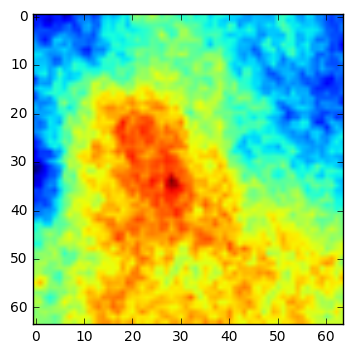

In [24]:
img_np=np.load('/home/seongjung/Desktop/temp1/train_4_img.npy')
print np.shape(img_np[1])
sample=np.reshape(img_np[600] , (64,64))
print sample
plt.imshow(sample)

In [13]:
fig = plt.figure()
for i in range(i):
    plt
    platte=plt.subplot(1,5,i)


NameError: name 'i' is not defined

In [ ]:

path1='/media/seongjung/새 볼륨/NCC/mammo_pic_128/0'
path2='/media/seongjung/새 볼륨/NCC/mammo_pic_128/2'
save_path='/home/seongjung/Desktop/temp'
train_rate=0.8
val_rate=0.1
img_row = 64
img_col = 64
color_ch=1
pic2numpy_TVT(path1 , path2 , train_rate , val_rate , save_path, img_row ,img_col, color_ch)

In [ ]:
print np.shape(np.load('/home/seongjung/Desktop/temp1/train_4_lab.npy'))

In [ ]:
import random
import numpy as np
dic_ = {} 
dic_['a'] =1
print dic_['a']
print dic_
print len(dic_)
s=list(range(5))
x= [i for i in range(10)]


print random.sample(x, len(x))

if dic_['a']==1:
    print "aaa"
    
np_= np.zeros([1,3])
np_=np.expand_dims(np_ ,3)
print np.shape(np_)

img_np=np.load('/home/seongjung/Desktop/temp1/test_img.npy')
print np.shape(img_np[1])
sample=np.reshape(img_np[0] , (64,64))
print sample
plt.imshow(sample)
"""
img_1=Image.open('/media/seongjung/새 볼륨/NCC/mammo_pic_128/0/0_1.bmp')
np_1=np.asarray(img_1)
print np.shape(np_1)
plt.imshow(np_1)
fig=plt.figure()
a=plt.subplot(1,1,1)
"""

In [ ]:
path_lst=Utility.crawl_folder('/home/ubuntu/Desktop/0/Training')
path_lst=ConstraintSize( path_lst ,1000 , 1000 )
np_lst,max_row,max_col=Set_ImageSize(path_lst)
img_size=(max_row,max_col)
Utility.pic2Numpy( np_lst , '/mnt/Jupyter/seongjung' , 30 ,'',img_size )


In [ ]:
import numpy as np
ds=np.load('/home/ncc/Desktop/plz_delete/00_0.npy')
print np.shape(ds[0])
re_ds=np.reshape(ds[4] , (515,465))
pylab.imshow(re_ds ,cmap = pylab.cm.bone)

In [ ]:
a=[]
a.append('3')
print a